In this file we extract core-user and non core users modify the non core users and give to myncf such that its accuracy decreases

In [1]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle
from sklearn.utils.extmath import randomized_svd

In [4]:
def ReadData():
    ml1m_dir = 'data/ratings.dat'
    ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    # v = tmp_df.uid.value_counts()
    # df = tmp_df[tmp_df.uid.isin(v.index[v.gt(30)])]
### code to store less than 30 interactions:
    # df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(30)])]
    return tmp_df, len(np.unique(mid_list)), len(unique_uid)

In [5]:
# threshold = 30 #split the users into test and train by threshold number of interactions. if greater than threshold then all interactions of that user goes into train set.
df, unique_mids, unique_uids = ReadData()
# print("GREATER THAN 30:\n", df_gt_30)
# print("LESS THAN 30: \n", df_le_30)
# print(len(df_gt_30))
# print(len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)
print("UNIQUE UIDS: ", unique_uids)


DICTIONARY PREPARED:
UNIQUE MIDS:  3706
UNIQUE UIDS:  6040


In [4]:
# support_test_df = df_gt_30.groupby("uid").tail(1)
# # print(len(df_gt_30))
# support_train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
# # print("#TEST INSTANCES: " ,len(support_test_df))
# # print("#TRAIN INSTANCES: " ,len(support_train_df))
# assert(len(df_gt_30)== len(support_test_df) + len(support_train_df))
# # print(len(test_df))
# # print(len(train_df))
# query_test_df = df_le_30.groupby("uid").tail(1)
# query_train_df = df_le_30.drop(df_le_30.groupby('uid').tail(1).index, inplace=False)
# assert(len(df_le_30)== len(query_test_df) + len(query_train_df))
# dic_support_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(support_train_df['uid']))])
# dic_support_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(support_train_df['uid']))])
# ### no need for mid mapping

# uid_of_train_df = support_train_df['uid'].tolist()
# for i in range(len(uid_of_train_df)):
#     uid_of_train_df[i] = dic_support_train_df_uid_mapping[uid_of_train_df[i]]
# # for index, row in train_df.iterrows():
# #     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
# core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':support_train_df['mid'], 'ratings':support_train_df['ratings']})

In [5]:
# train_ui_dic = {}    
# for user in range(unique_uids):
#     train_ui_dic[user] = []
# for index,row in support_train_df.iterrows():
#         train_ui_dic[row['uid']].append(row['mid'])

- utility functions for CUR coreusers.

In [6]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len, percent_core_user=0.40):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)
    
    unique_uid = np.unique(np.array(dataframe['uid'].tolist()))
    assert(u_len == len(unique_uid))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    rev_uid_dict = dict([(x,y) for x,y in enumerate(unique_uid)])
    
    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    
    r_ind = twentyPercentUserList
    len_r_ind = len(r_ind)
    new_r_ind = [rev_uid_dict[r_ind[i]] for i in range(len_r_ind)]
    cos_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(new_r_ind))]
    # coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return cos_coreusers

In [7]:
MAX_MID = 27277 + 1
def select_cols(mat, k, dup=False):
    # prob 1d array of probabilities of all columns
    prob = mat.T.dot(mat)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis = 0)
    prob = prob/denom

    C = np.zeros((mat.shape[0], k))
    ind_cols = np.arange(0, prob.size)
    c_ind = []
    i = 0
    while(i < k):
        rand_sel = np.random.choice(ind_cols, 1, p=prob)
        if rand_sel in c_ind:
            continue
        c_ind.append(rand_sel[0])
        C[:, i] = mat[:, rand_sel[0]]
        i += 1
        # C[:, i] = C[:, i]/np.sqrt(k*prob[rand_sel[0]])

    return C, c_ind

def select_rows(mat, k, dup=False):

    prob = mat.dot(mat.T)
    prob = np.array(np.diagonal(prob))
    denom = np.abs(prob).sum(axis=0)
    prob = prob/denom
    print(prob)
    r = np.zeros((k, mat.shape[1]))
    ind_rows = np.arange(0, prob.size)
    r_ind = []
    i = 0
    while(i < k):
        # print(ind_rows)
        rand_sel = np.random.choice(ind_rows, 1, p=prob)
        if rand_sel in r_ind:
            continue
        r_ind.append(rand_sel[0])
        r[i, :] = mat[rand_sel[0], :]
        i += 1
        # r[i, :] = r[i, :]/np.sqrt(k*prob[rand_sel[0]])
    r_ind = np.array(r_ind)
    return r, r_ind

# def matIntersection(mat, c_ind, r_ind):
    
#     W = np.zeros((len(r_ind), len(c_ind)))
#     for i in range(len(r_ind)):
#         W[i] = mat[r_ind[i], c_ind]
    
#     return W

# def pseudoInverse(W):
#     # U = WP (W+)

#     # W = X.Z.YT
#     X, Z, YT = np.linalg.svd(W)
    
#     # W+ = Y.Z+.XT
#     XT = X.T
#     Y = YT.T
#     # Z+ = reciprocal(Z)
#     ZP = np.reciprocal(Z)
#     ZP = sp.spdiags(ZP, 0, ZP.size, ZP.size)
#     ZP = ZP@ZP
    
#     # W+ = Y.Z+.XT
#     WP = Y@ZP
#     WP = WP@XT

#     return WP

In [8]:
def CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len, percent_core_user=0.40):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    
    # print(userItemMatrix)

    unique_uid = np.unique(np.array(dataframe['uid'].tolist()))
    assert(u_len == len(unique_uid))
    # print("UNIQUE UID:", unique_uid)
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    rev_uid_dict = dict([(x,y) for x,y in enumerate(unique_uid)])

    userItemMatrix = np.zeros(shape=(u_len, m_len))
    for index, row in dataframe.iterrows():
        userItemMatrix[uid_dict[row['uid']]][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    C, c_ind = select_cols(mat, int(u_len * percent_core_user)) ## getting 20% core users
    r, r_ind= select_rows(mat, int(u_len * percent_core_user))
    # print("r", r)
    # print("r_ind len", len(r_ind))

    len_r_ind = len(r_ind)
    new_r_ind = [rev_uid_dict[r_ind[i]] for i in range(len_r_ind)]
    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(new_r_ind))]
    # # coreusers.reset_index()
    # # print("CORE USERS:\n", coreusers)
    return cur_coreusers

In [9]:
def RandomSampling(dataframe, unique_user_len, unique_item_len, percent_core_user=0.40):
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)

    how_much_to_sample = int(percent_core_user * u_len)
    indices = random.sample(range(u_len), how_much_to_sample)
    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(indices))]
    return cur_coreusers

In [10]:
class largest_leveragescores_Sampler:
    def __init__(self, A, k, Q,N):
        """ Create largest k-leverage scores Sampler for the matrix :math:`A` for k-low rank apparoximation.
        :param A: 
            Matrix :math:`A`.
        :type A: 
            array_type
        :param Q: 
            Matrix containig the right singular vectors of :math:`A`.
        :type Q: 
            array_type
        :param k: 
            The order of low rank apparoximation.
        :type k: 
            int
        :param N: 
            The dimension of subsampling (the number of columns) of A.
        :type N: 
            int
        """
        self.A = A
        # print("k is", type(k))
        self.Q = np.transpose(Q[0:k,:])
        self.N = N
        self.k = k
        
        self.sampling_list = []
        self.lvs_array = self.Estimate_Leverage_Scores()
    def Estimate_Leverage_Scores(self):
        return 1/(self.k)*np.diag(np.dot(self.Q,self.Q.T))
    def MultiRounds(self):
        temp_list = list(reversed(np.argsort(self.lvs_array)))
        sampled_indices_ = temp_list[0:self.k]
        self.sampling_list = sampled_indices_
        return sampled_indices_
from scipy.sparse.linalg import svds
def Extract_LLS(dataframe, unique_user_len, unique_item_len, percent_core_user=0.40):
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    
    # print(userItemMatrix)

    unique_uid = np.unique(np.array(dataframe['uid'].tolist()))
    assert(u_len == len(unique_uid))
    # print("UNIQUE UID:", unique_uid)
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    rev_uid_dict = dict([(x,y) for x,y in enumerate(unique_uid)])

    userItemMatrix = np.zeros(shape=(u_len, m_len))
    for index, row in dataframe.iterrows():
        userItemMatrix[uid_dict[int(row['uid'])]][int(row['mid'])] = int(row['ratings'])
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)
    A = userItemMatrix.T
    number_of_coreusers = int(u_len * percent_core_user)
    print(number_of_coreusers)
    u4, s4, Q = svds(A, k=number_of_coreusers)
    lls = largest_leveragescores_Sampler(A, number_of_coreusers, Q, number_of_coreusers)
    indx = lls.MultiRounds()
    # indx = indx.
    print("LENGTH OF INDEX:", len(indx))
    print("INDICES ARE:", indx)
    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(indx))]
    # # coreusers.reset_index()
    # # print("CORE USERS:\n", coreusers)
    return cur_coreusers

- cur decomposition from paper (https://www.pnas.org/doi/10.1073/pnas.0803205106) called optimal cur

In [11]:
class CUR():
    def __init__(self, k, eps, it=None, truncated=False):
        self.k = k
        print("K IS :", self.k)
        self.eps = eps
        self.trunc = truncated 
        self.c = k * np.log(k) / eps**2 #expectation number of sampled columns
        self.C, self.U, self.R = None, None, None #matrices of decomposition
        self.pi_col, self.pi_row = None, None #leverage scores of corresponding columns/rows
        self.col_indices = None
        self.row_indices = None
    
    def column_select(self, A):
        n = A.shape[1]
        A = np.array(A.copy())
        if self.trunc:
            _, _, v_k = randomized_svd(A, self.k) #for very big matrices
        else:
            _, _, vh = np.linalg.svd(A, full_matrices=False)
            v_k = vh[0:self.k, :]
        
        pi = 1 / self.k * np.sum(v_k**2, axis=0)
        c_index = [np.random.choice(2, 
                        p=[1 - min(1, self.c * pi[i]), min(1, self.c * pi[i])]) for i in range(n)
                  ]
        c_index = np.nonzero(c_index)[0]
        print(len(c_index))
        C = A[:, c_index]
        return C, c_index, pi

    def run_CUR(self, A):
        A = np.array(A.copy())
        # self.C, self.col_indices, self.pi_col = self.column_select(A)
        self.R, self.row_indices, self.pi_row = self.column_select(A.T)
        # self.U = np.linalg.pinv(self.C) @ A @ np.linalg.pinv(self.R.T)
        return self.row_indices
def OPTIMAL_CUR_ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    mat = userItemMatrix
    print("MAT:", mat)
    print(mat.shape)
    cur = CUR(k=int(u_len * 0.10), eps=0.5,)
    # ids = np.argsort(cur.pi_col)[::-1][:5]
    cur.run_CUR(mat)
    cur_coreusers_idx = np.argsort(cur.pi_row)[::-1][:int(u_len * 0.10)]
    cur_coreusers = dataframe.iloc[np.where(dataframe.uid.isin(cur_coreusers_idx))]
    # print(len(cur_coreusers))
    return cur_coreusers

In [12]:
# core_users = CUR_ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids, percent_core_user=0.40)
# sdf.to_csv('file_name.csv', index=False)
# core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
# core_users = RandomSampling(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids, percent_core_user=0.40)
core_users = Extract_LLS(df, len(np.unique(df['uid'])), unique_mids, percent_core_user=0.40)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)
print("NUMBER OF CORE USERS:", len(support_user_list))

USER LEN: 6040
MOVIE LEN: 3706
USER ITEM MATRIX: 
 [[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
2416
LENGTH OF INDEX: 2416
INDICES ARE: [4168, 4276, 1679, 3031, 1068, 3538, 194, 1469, 1241, 3840, 888, 1940, 1447, 3223, 2908, 1697, 849, 548, 5110, 4681, 4646, 3617, 1979, 1732, 5099, 3490, 423, 1014, 730, 2123, 1149, 677, 523, 351, 3291, 1284, 3066, 3390, 5830, 1180, 3841, 1644, 2062, 3833, 1273, 52, 1604, 4481, 1424, 1834, 751, 3984, 4447, 2115, 5332, 4047, 2506, 2985, 4818, 1740, 4343, 1265, 1670, 1811, 1763, 672, 2906, 6015, 5316, 5811, 6035, 186, 1223, 3884, 4770, 2776, 1087, 4084, 1297, 5953, 542, 4507, 2303, 1925, 4304, 4063, 3271, 1450, 3807, 1448, 5510, 5877, 5794, 1836, 4040, 868, 1896, 4020, 3822, 2792, 4053, 3828, 1146, 1316, 5045, 2819, 3625, 3704, 172, 4353, 3791, 4542, 549, 2528, 5393, 4410, 3366, 1757, 5754, 880, 4815, 215, 3162, 1748, 854, 330, 1634, 2877, 1736, 

### CODE SNIPPET FOR GETTING NESTED CORE USERS:

In [13]:
core_users_nested = CUR_ExtractCoreUsers(core_users, len(np.unique(core_users['uid'])), unique_mids, percent_core_user=0.50)
print(len(np.unique(core_users_nested['uid'])))
print("NESTED CORE USERS:\n" ,core_users_nested)

USER LEN: 2416
MOVIE LEN: 3706
USER ITEM MATRIX: 
 [[0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 5. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
MAT: [[0. 0. 0. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [5. 5. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
(2416, 3706)
[0.00020753 0.00020781 0.00066301 ... 0.00099564 0.00027636 0.0004537 ]
1208
NESTED CORE USERS:
          uid   mid  ratings
254        4  2775        4
255        4  2140        4
256        4  1087        5
257        4    38        3
258        4   279        2
...      ...   ...      ...
999720  6036  1008        4
999721  6036  1014        4
999722  6036  1017        3
999723  6036   548        4
999724  6036  1025        5

[474791 rows x 3 columns]


#### CODE SNIPPET FOR GETTING NESTED CORE USER

In [15]:
core_users_index_list_nested = core_users_nested.index.to_list()
non_core_user_index = (df.index.difference(core_users.index))
non_core_user_index = non_core_user_index.tolist()

core_users_df_nested = df.loc[core_users_index_list_nested]
non_core_user_df = df.loc[non_core_user_index]
print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:", core_users_nested)

NON CORE USERS:          uid   mid  ratings
0          0  1104        5
1          0   639        3
2          0   853        3
3          0  3177        4
4          0  2162        5
...      ...   ...      ...
999863  6038  1009        4
999864  6038  1011        3
999865  6038  1014        4
999866  6038  1016        4
999867  6038  1025        4

[230414 rows x 3 columns]
CORE USERS:          uid   mid  ratings
254        4  2775        4
255        4  2140        4
256        4  1087        5
257        4    38        3
258        4   279        2
...      ...   ...      ...
999720  6036  1008        4
999721  6036  1014        4
999722  6036  1017        3
999723  6036   548        4
999724  6036  1025        5

[474791 rows x 3 columns]


In [16]:
support_test_df = core_users_df_nested.groupby("uid").tail(1)
# print(len(df_gt_30))
support_train_df = core_users_df_nested.drop(core_users_df_nested.groupby('uid').tail(1).index, inplace=False)
# print("#TEST INSTANCES: " ,len(support_test_df))
# print("#TRAIN INSTANCES: " ,len(support_train_df))
assert(len(core_users_df_nested) == len(support_test_df) + len(support_train_df))
# print(len(test_df))
# print(len(train_df))
query_test_df = non_core_user_df.groupby("uid").tail(1)
query_train_df = non_core_user_df.drop(non_core_user_df.groupby('uid').tail(1).index, inplace=False)
assert(len(non_core_user_df)== len(query_test_df) + len(query_train_df))

In [17]:
train_ui_dic = {}    
for user in range(unique_uids):
    train_ui_dic[user] = []
for index,row in support_train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

#### CODE SNIPPET FOR GETTING NESTED CORE USER

In [18]:
unique_uids_in_support_trian = np.unique(np.array(core_users_df_nested['uid']))
unique_uids_in_query_trian = np.unique(query_train_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = support_test_df.loc[support_test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = query_test_df
print("QUERY TEST DF:\n", query_test_df)

1208
SUPPORT TEST DF:          uid   mid  ratings
451        4   683        4
1199       9  1868        5
1336      10  1152        4
1939      16  2773        5
2244      17  1154        5
...      ...   ...      ...
995572  6010  1865        5
995719  6012   548        5
996791  6015  3540        4
997442  6022  1017        1
999724  6036  1025        5

[1208 rows x 3 columns]
QUERY TEST DF:
          uid   mid  ratings
52         0  1154        4
181        1  1155        5
232        2  1900        4
253        3  1148        5
522        5    33        4
...      ...   ...      ...
998273  6031  1012        2
998333  6032  1848        5
998354  6033   527        5
999744  6037  1007        5
999867  6038  1025        4

[3624 rows x 3 columns]


#### CODE SNIPPET FOR GETTING NESTED CORE USER

In [19]:
support_train = []
for index,row in core_users_df_nested.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in query_train_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df_nested['uid']).tolist()

In [20]:
import pickle
with open("input_for_getting_query_embeddings.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

Getting embeddings for query users and which we will use to mul

In [22]:
!python pretrain-1m.py
!python train-1m.py
# !python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 474791/226790
test set size: support/query 1208/3624
Epoch 0 Step 441: Train 1.8473 Reg: 0.5707
Test: 0.7986 MAE: 0.7136 RMSE: 0.8936
Val: 0.8094 MAE: 0.7109 RMSE: 0.8997
Epoch 1 Step 882: Train 0.8168 Reg: 0.4363
Test: 0.7943 MAE: 0.7073 RMSE: 0.8912
Val: 0.8037 MAE: 0.7092 RMSE: 0.8965
Epoch 2 Step 1323: Train 0.8131 Reg: 0.3538
Test: 0.7955 MAE: 0.7112 RMSE: 0.8919
Val: 0.8012 MAE: 0.7076 RMSE: 0.8951
Epoch 3 Step 1764: Train 0.8079 Reg: 0.3152
Test: 0.8019 MAE: 0.7061 RMSE: 0.8955
Val: 0.7943 MAE: 0.7023 RMSE: 0.8912
Epoch 4 Step 2205: Train 0.7967 Reg: 0.3053
Test: 0.7890 MAE: 0.7046 RMSE: 0.8882
Val: 0.7837 MAE: 0.6995 RMSE: 0.8852
Epoch 5 Step 2646: Train 0.7779 Reg: 0.3112
Test: 0.7681 MAE: 0.6885 RMSE: 0.8764
Val: 0.7643 MAE: 0.6885 RMSE: 0.8743
Epoch 6 Step 3087: Train 0.7627 Reg: 0.3066
Test: 0.7618 MAE: 0.6843 RMSE: 0.8728
Val: 0.7535 MAE: 0.6824 RMSE: 0.8681

LLS sampling 40% and then CUR coreuser 50% effective 20%users

In [16]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 439388/19100
test set size: support/query 1046/809
Epoch 0 Step 408: Train 1.9740 Reg: 0.5686
Test: 0.8228 MAE: 0.7280 RMSE: 0.9071
Val: 0.7987 MAE: 0.7085 RMSE: 0.8937
Epoch 1 Step 816: Train 0.8042 Reg: 0.4413
Test: 0.8204 MAE: 0.7263 RMSE: 0.9057
Val: 0.7971 MAE: 0.7066 RMSE: 0.8928
Epoch 2 Step 1224: Train 0.8009 Reg: 0.3585
Test: 0.8122 MAE: 0.7216 RMSE: 0.9012
Val: 0.7946 MAE: 0.7084 RMSE: 0.8914
Epoch 3 Step 1632: Train 0.7980 Reg: 0.3133
Test: 0.8011 MAE: 0.7163 RMSE: 0.8951
Val: 0.7911 MAE: 0.7055 RMSE: 0.8894
Epoch 4 Step 2040: Train 0.7947 Reg: 0.2881
Test: 0.8032 MAE: 0.7144 RMSE: 0.8962
Val: 0.7846 MAE: 0.7027 RMSE: 0.8858
Epoch 5 Step 2448: Train 0.7902 Reg: 0.2725
Test: 0.8044 MAE: 0.7187 RMSE: 0.8969
Val: 0.7843 MAE: 0.7024 RMSE: 0.8856
Epoch 6 Step 2856: Train 0.7832 Reg: 0.2641
Test: 0.8140 MAE: 0.7209 RMSE: 0.9022
Val: 0.7724 MAE: 0.6936 RMSE: 0.8789
E

Nested ml1m 40-50 cur input to IDCF

In [15]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 407656/19100
test set size: support/query 1046/809
Epoch 0 Step 379: Train 1.2150 Reg: 0.6210
Test: 0.8129 MAE: 0.7267 RMSE: 0.9016
Val: 0.7963 MAE: 0.7067 RMSE: 0.8924
Epoch 1 Step 758: Train 0.7784 Reg: 0.5679
Test: 0.7425 MAE: 0.6862 RMSE: 0.8617
Val: 0.7649 MAE: 0.6911 RMSE: 0.8746
Epoch 2 Step 1137: Train 0.7473 Reg: 0.5873
Test: 0.7377 MAE: 0.6777 RMSE: 0.8589
Val: 0.7434 MAE: 0.6752 RMSE: 0.8622
Epoch 3 Step 1516: Train 0.7269 Reg: 0.5840
Test: 0.7570 MAE: 0.6889 RMSE: 0.8701
Val: 0.7333 MAE: 0.6712 RMSE: 0.8563
Epoch 4 Step 1895: Train 0.7119 Reg: 0.5836
Test: 0.7321 MAE: 0.6762 RMSE: 0.8556
Val: 0.7217 MAE: 0.6665 RMSE: 0.8495
Epoch 5 Step 2274: Train 0.7025 Reg: 0.5792
Test: 0.7446 MAE: 0.6762 RMSE: 0.8629
Val: 0.7254 MAE: 0.6646 RMSE: 0.8517
Epoch 6 Step 2653: Train 0.6955 Reg: 0.5824
Test: 0.7145 MAE: 0.6631 RMSE: 0.8453
Val: 0.7187 MAE: 0.6617 RMSE: 0.8478
E

Random sampling nested ml1m 40-50 cur input to IDCF

In [29]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 288576/19100
test set size: support/query 322/809
Epoch 0 Step 268: Train 1.3841 Reg: 0.6287
Test: 0.8858 MAE: 0.7462 RMSE: 0.9412
Val: 0.8231 MAE: 0.7200 RMSE: 0.9073
Epoch 1 Step 536: Train 0.8057 Reg: 0.6206
Test: 0.8582 MAE: 0.7234 RMSE: 0.9264
Val: 0.7894 MAE: 0.6994 RMSE: 0.8885
Epoch 2 Step 804: Train 0.7752 Reg: 0.6143
Test: 0.8555 MAE: 0.7159 RMSE: 0.9249
Val: 0.7672 MAE: 0.6916 RMSE: 0.8759
Epoch 3 Step 1072: Train 0.7558 Reg: 0.6206
Test: 0.8628 MAE: 0.7231 RMSE: 0.9289
Val: 0.7547 MAE: 0.6864 RMSE: 0.8687
Epoch 4 Step 1340: Train 0.7356 Reg: 0.6668
Test: 0.8579 MAE: 0.7265 RMSE: 0.9262
Val: 0.7455 MAE: 0.6783 RMSE: 0.8634
Epoch 5 Step 1608: Train 0.7140 Reg: 0.7285
Test: 0.8587 MAE: 0.7290 RMSE: 0.9267
Val: 0.7315 MAE: 0.6741 RMSE: 0.8553
Epoch 6 Step 1876: Train 0.6950 Reg: 0.7601
Test: 0.8426 MAE: 0.7244 RMSE: 0.9179
Val: 0.7278 MAE: 0.6732 RMSE: 0.8531
Epo

- 20% cur coreusers into IDCF

In [43]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 350454/19100
test set size: support/query 1046/809
Epoch 0 Step 326: Train 2.3744 Reg: 0.5801
Test: 0.8841 MAE: 0.7485 RMSE: 0.9403
Val: 0.8295 MAE: 0.7204 RMSE: 0.9108
Epoch 1 Step 652: Train 0.8227 Reg: 0.4742
Test: 0.8720 MAE: 0.7455 RMSE: 0.9338
Val: 0.8162 MAE: 0.7159 RMSE: 0.9034
Epoch 2 Step 978: Train 0.8162 Reg: 0.3923
Test: 0.8831 MAE: 0.7473 RMSE: 0.9397
Val: 0.8117 MAE: 0.7120 RMSE: 0.9010
Epoch 3 Step 1304: Train 0.8133 Reg: 0.3389
Test: 0.8575 MAE: 0.7363 RMSE: 0.9260
Val: 0.8067 MAE: 0.7109 RMSE: 0.8982
Epoch 4 Step 1630: Train 0.8103 Reg: 0.3066
Test: 0.8620 MAE: 0.7369 RMSE: 0.9284
Val: 0.8071 MAE: 0.7100 RMSE: 0.8984
Epoch 5 Step 1956: Train 0.8064 Reg: 0.2876
Test: 0.8742 MAE: 0.7433 RMSE: 0.9350
Val: 0.8034 MAE: 0.7067 RMSE: 0.8963
Epoch 6 Step 2282: Train 0.8025 Reg: 0.2758
Test: 0.8604 MAE: 0.7388 RMSE: 0.9276
Val: 0.7992 MAE: 0.7075 RMSE: 0.8940
Ep

- 10% CUR coueusers to IDCF

In [42]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 181085/19100
test set size: support/query 523/809
Epoch 0 Step 168: Train 3.6543 Reg: 0.5106
Test: 0.9035 MAE: 0.7842 RMSE: 0.9506
Val: 0.8944 MAE: 0.7500 RMSE: 0.9457
Epoch 1 Step 336: Train 0.8412 Reg: 0.4776
Test: 0.8339 MAE: 0.7370 RMSE: 0.9132
Val: 0.8397 MAE: 0.7243 RMSE: 0.9164
Epoch 2 Step 504: Train 0.8179 Reg: 0.4384
Test: 0.8199 MAE: 0.7289 RMSE: 0.9055
Val: 0.8333 MAE: 0.7230 RMSE: 0.9129
Epoch 3 Step 672: Train 0.8120 Reg: 0.4062
Test: 0.8104 MAE: 0.7268 RMSE: 0.9002
Val: 0.8261 MAE: 0.7184 RMSE: 0.9089
Epoch 4 Step 840: Train 0.8091 Reg: 0.3781
Test: 0.8072 MAE: 0.7271 RMSE: 0.8984
Val: 0.8276 MAE: 0.7198 RMSE: 0.9097
Epoch 5 Step 1008: Train 0.8074 Reg: 0.3540
Test: 0.8100 MAE: 0.7274 RMSE: 0.9000
Val: 0.8269 MAE: 0.7192 RMSE: 0.9093
Epoch 6 Step 1176: Train 0.8061 Reg: 0.3343
Test: 0.8202 MAE: 0.7295 RMSE: 0.9056
Val: 0.8256 MAE: 0.7187 RMSE: 0.9086
Epoch

- 60% CUR core user as input to IDCF

In [44]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 789731/19100
test set size: support/query 3138/809
Epoch 0 Step 733: Train 1.5780 Reg: 0.6163
Test: 0.8974 MAE: 0.7530 RMSE: 0.9473
Val: 0.8343 MAE: 0.7252 RMSE: 0.9134
Epoch 1 Step 1466: Train 0.8332 Reg: 0.3995
Test: 0.8914 MAE: 0.7469 RMSE: 0.9441
Val: 0.8254 MAE: 0.7209 RMSE: 0.9085
Epoch 2 Step 2199: Train 0.8279 Reg: 0.3445
Test: 0.8778 MAE: 0.7447 RMSE: 0.9369
Val: 0.8206 MAE: 0.7181 RMSE: 0.9059
Epoch 3 Step 2932: Train 0.8215 Reg: 0.3114
Test: 0.8715 MAE: 0.7424 RMSE: 0.9335
Val: 0.8159 MAE: 0.7185 RMSE: 0.9033
Epoch 4 Step 3665: Train 0.8108 Reg: 0.2929
Test: 0.8789 MAE: 0.7421 RMSE: 0.9375
Val: 0.8003 MAE: 0.7090 RMSE: 0.8946
Epoch 5 Step 4398: Train 0.7949 Reg: 0.2933
Test: 0.8668 MAE: 0.7350 RMSE: 0.9310
Val: 0.7843 MAE: 0.6988 RMSE: 0.8856
Epoch 6 Step 5131: Train 0.7749 Reg: 0.3176
Test: 0.8413 MAE: 0.7182 RMSE: 0.9172
Val: 0.7647 MAE: 0.6878 RMSE: 0.8745


- 40% CUR coreusers input to IDCF

In [45]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 601508/19100
test set size: support/query 2092/809
Epoch 0 Step 559: Train 1.7367 Reg: 0.6178
Test: 0.8674 MAE: 0.7415 RMSE: 0.9313
Val: 0.8281 MAE: 0.7198 RMSE: 0.9100
Epoch 1 Step 1118: Train 0.8199 Reg: 0.4178
Test: 0.8714 MAE: 0.7433 RMSE: 0.9335
Val: 0.8177 MAE: 0.7142 RMSE: 0.9043
Epoch 2 Step 1677: Train 0.8154 Reg: 0.3411
Test: 0.8585 MAE: 0.7379 RMSE: 0.9265
Val: 0.8177 MAE: 0.7152 RMSE: 0.9043
Epoch 3 Step 2236: Train 0.8114 Reg: 0.3114
Test: 0.8584 MAE: 0.7350 RMSE: 0.9265
Val: 0.8129 MAE: 0.7140 RMSE: 0.9016
Epoch 4 Step 2795: Train 0.8065 Reg: 0.2894
Test: 0.8419 MAE: 0.7302 RMSE: 0.9176
Val: 0.8071 MAE: 0.7106 RMSE: 0.8984
Epoch 5 Step 3354: Train 0.8000 Reg: 0.2711
Test: 0.8575 MAE: 0.7325 RMSE: 0.9260
Val: 0.7999 MAE: 0.7054 RMSE: 0.8944
Epoch 6 Step 3913: Train 0.7908 Reg: 0.2576
Test: 0.8478 MAE: 0.7295 RMSE: 0.9207
Val: 0.7921 MAE: 0.7005 RMSE: 0.8900


- 10% optimal cur to IDCF

In [58]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 321973/19100
test set size: support/query 523/809
Epoch 0 Step 299: Train 2.4073 Reg: 0.5220
Test: 0.7121 MAE: 0.6744 RMSE: 0.8439
Val: 0.8141 MAE: 0.7106 RMSE: 0.9023
Epoch 1 Step 598: Train 0.7942 Reg: 0.4424
Test: 0.6925 MAE: 0.6669 RMSE: 0.8322
Val: 0.8084 MAE: 0.7104 RMSE: 0.8991
Epoch 2 Step 897: Train 0.7902 Reg: 0.3834
Test: 0.6863 MAE: 0.6577 RMSE: 0.8284
Val: 0.8066 MAE: 0.7080 RMSE: 0.8981
Epoch 3 Step 1196: Train 0.7875 Reg: 0.3426
Test: 0.6751 MAE: 0.6581 RMSE: 0.8216
Val: 0.8069 MAE: 0.7094 RMSE: 0.8983
Epoch 4 Step 1495: Train 0.7847 Reg: 0.3154
Test: 0.6914 MAE: 0.6637 RMSE: 0.8315
Val: 0.8040 MAE: 0.7060 RMSE: 0.8966
Epoch 5 Step 1794: Train 0.7814 Reg: 0.2948
Test: 0.6873 MAE: 0.6575 RMSE: 0.8290
Val: 0.8003 MAE: 0.7055 RMSE: 0.8946
Epoch 6 Step 2093: Train 0.7780 Reg: 0.2793
Test: 0.6755 MAE: 0.6528 RMSE: 0.8219
Val: 0.7938 MAE: 0.7017 RMSE: 0.8910
Epo

- 20% optimal cur to IDCF

In [1]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 508216/19100
test set size: support/query 1046/809
Epoch 0 Step 472: Train 1.8475 Reg: 0.5739
Test: 0.7647 MAE: 0.6982 RMSE: 0.8745
Val: 0.8158 MAE: 0.7139 RMSE: 0.9032
Epoch 1 Step 944: Train 0.8043 Reg: 0.4398
Test: 0.7866 MAE: 0.7040 RMSE: 0.8869
Val: 0.8094 MAE: 0.7112 RMSE: 0.8996
Epoch 2 Step 1416: Train 0.8003 Reg: 0.3541
Test: 0.7623 MAE: 0.6944 RMSE: 0.8731
Val: 0.8032 MAE: 0.7077 RMSE: 0.8962
Epoch 3 Step 1888: Train 0.7965 Reg: 0.3092
Test: 0.7586 MAE: 0.6926 RMSE: 0.8710
Val: 0.7998 MAE: 0.7072 RMSE: 0.8943
Epoch 4 Step 2360: Train 0.7904 Reg: 0.2852
Test: 0.7573 MAE: 0.6866 RMSE: 0.8702
Val: 0.7915 MAE: 0.7026 RMSE: 0.8896
Epoch 5 Step 2832: Train 0.7771 Reg: 0.2790
Test: 0.7407 MAE: 0.6832 RMSE: 0.8606
Val: 0.7753 MAE: 0.6938 RMSE: 0.8805
Epoch 6 Step 3304: Train 0.7605 Reg: 0.2787
Test: 0.7327 MAE: 0.6782 RMSE: 0.8560
Val: 0.7632 MAE: 0.6872 RMSE: 0.8736
E

- 40% optimal cur

In [2]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 726169/19100
test set size: support/query 2092/809
Epoch 0 Step 674: Train 1.6229 Reg: 0.6160
Test: 0.8437 MAE: 0.7339 RMSE: 0.9185
Val: 0.8446 MAE: 0.7291 RMSE: 0.9190
Epoch 1 Step 1348: Train 0.8316 Reg: 0.3984
Test: 0.8348 MAE: 0.7274 RMSE: 0.9137
Val: 0.8389 MAE: 0.7260 RMSE: 0.9159
Epoch 2 Step 2022: Train 0.8271 Reg: 0.3340
Test: 0.8556 MAE: 0.7398 RMSE: 0.9250
Val: 0.8344 MAE: 0.7224 RMSE: 0.9135
Epoch 3 Step 2696: Train 0.8221 Reg: 0.3043
Test: 0.8390 MAE: 0.7278 RMSE: 0.9159
Val: 0.8288 MAE: 0.7215 RMSE: 0.9104
Epoch 4 Step 3370: Train 0.8126 Reg: 0.2827
Test: 0.8299 MAE: 0.7243 RMSE: 0.9110
Val: 0.8140 MAE: 0.7139 RMSE: 0.9022
Epoch 5 Step 4044: Train 0.7972 Reg: 0.2694
Test: 0.8172 MAE: 0.7113 RMSE: 0.9040
Val: 0.8033 MAE: 0.7062 RMSE: 0.8963
Epoch 6 Step 4718: Train 0.7865 Reg: 0.2498
Test: 0.8197 MAE: 0.7148 RMSE: 0.9054
Val: 0.7946 MAE: 0.7026 RMSE: 0.8914


- 60% optimal cur

In [2]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 838282/19100
test set size: support/query 3138/809
Epoch 0 Step 778: Train 1.5637 Reg: 0.6184
Test: 0.9154 MAE: 0.7569 RMSE: 0.9568
Val: 0.8492 MAE: 0.7298 RMSE: 0.9215
Epoch 1 Step 1556: Train 0.8439 Reg: 0.4015
Test: 0.9039 MAE: 0.7536 RMSE: 0.9507
Val: 0.8439 MAE: 0.7266 RMSE: 0.9186
Epoch 2 Step 2334: Train 0.8379 Reg: 0.3468
Test: 0.8898 MAE: 0.7505 RMSE: 0.9433
Val: 0.8397 MAE: 0.7252 RMSE: 0.9164
Epoch 3 Step 3112: Train 0.8295 Reg: 0.2993
Test: 0.8890 MAE: 0.7428 RMSE: 0.9429
Val: 0.8290 MAE: 0.7180 RMSE: 0.9105
Epoch 4 Step 3890: Train 0.8177 Reg: 0.2650
Test: 0.8788 MAE: 0.7414 RMSE: 0.9374
Val: 0.8171 MAE: 0.7142 RMSE: 0.9040
Epoch 5 Step 4668: Train 0.8038 Reg: 0.2564
Test: 0.8772 MAE: 0.7357 RMSE: 0.9366
Val: 0.8036 MAE: 0.7058 RMSE: 0.8964
Epoch 6 Step 5446: Train 0.7915 Reg: 0.2587
Test: 0.8626 MAE: 0.7313 RMSE: 0.9287
Val: 0.7969 MAE: 0.7028 RMSE: 0.8927


- 80% optimal cur

In [1]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 921625/19100
test set size: support/query 4184/809
Epoch 0 Step 856: Train 1.4599 Reg: 0.6109
Test: 0.9337 MAE: 0.7677 RMSE: 0.9663
Val: 0.8592 MAE: 0.7334 RMSE: 0.9269
Epoch 1 Step 1712: Train 0.8481 Reg: 0.4128
Test: 0.9246 MAE: 0.7658 RMSE: 0.9616
Val: 0.8518 MAE: 0.7314 RMSE: 0.9229
Epoch 2 Step 2568: Train 0.8420 Reg: 0.3619
Test: 0.9058 MAE: 0.7521 RMSE: 0.9518
Val: 0.8438 MAE: 0.7250 RMSE: 0.9186
Epoch 3 Step 3424: Train 0.8323 Reg: 0.3190
Test: 0.9146 MAE: 0.7639 RMSE: 0.9563
Val: 0.8333 MAE: 0.7239 RMSE: 0.9128
Epoch 4 Step 4280: Train 0.8166 Reg: 0.2902
Test: 0.8959 MAE: 0.7459 RMSE: 0.9465
Val: 0.8166 MAE: 0.7125 RMSE: 0.9037
Epoch 5 Step 5136: Train 0.8017 Reg: 0.2794
Test: 0.8876 MAE: 0.7459 RMSE: 0.9421
Val: 0.7994 MAE: 0.7052 RMSE: 0.8941
Epoch 6 Step 5992: Train 0.7767 Reg: 0.3323
Test: 0.8611 MAE: 0.7358 RMSE: 0.9279
Val: 0.7786 MAE: 0.6978 RMSE: 0.8824


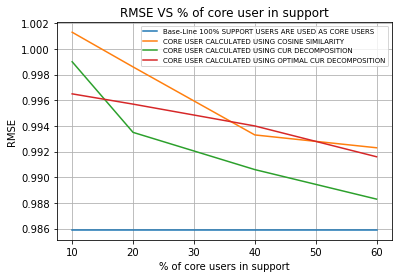

In [2]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.0013,0.9986,0.9933, 0.9923]
x1_axis = [10, 20, 40, 60]
y1_axis = [0.9859, 0.9859, 0.9859, 0.9859]
x2_axis = [10, 20, 40, 60]
y2_axis = [0.9990, 0.9935, 0.9906, 0.9883]
x4_axis = [10, 20, 40, 60]
y4_axis = [0.9965, 0.9957, 0.9940, 0.9916]
plt.plot(x1_axis, y1_axis, label="Base-Line 100% SUPPORT USERS ARE USED AS CORE USERS")
plt.plot(x_axis, y_axis, label="CORE USER CALCULATED USING COSINE SIMILARITY")
plt.plot(x2_axis, y2_axis, label="CORE USER CALCULATED USING CUR DECOMPOSITION")
plt.plot(x4_axis, y4_axis, label="CORE USER CALCULATED USING OPTIMAL CUR DECOMPOSITION")

plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend(fontsize=7)
plt.show()